In [108]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from scipy import stats
from scipy import stats
import math
from sklearn.preprocessing import MinMaxScaler,PolynomialFeatures, StandardScaler
from sklearn import tree,linear_model,neighbors
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error,r2_score
%matplotlib inline
import warnings 
warnings.filterwarnings("ignore")
sns.set(style="white", color_codes=True)
sns.set_context(rc={"font.family":'sans',"font.size":10,"axes.titlesize":24,"axes.labelsize":24}) 
from sklearn import model_selection

# Upload data (customers model)

In [109]:
train=pd.read_csv('TrainClean.csv',index_col=0).reset_index(drop=True)
test=pd.read_csv('TestClean.csv',index_col=0).reset_index(drop=True)

columnscustomer_lasso=['HasPromotions', 'NearestCompetitor', 'Region_AreaKM2',
       'Mean_Dew_PointC', 'Mean_Sea_Level_PressurehPa', 'Mean_VisibilityKm',
       'Precipitationmm', 'StandardMarket', 'HyperMarket', 'ShoppingCenter',
       'General', 'WithFishDepartment', 'Region0', 'Region1', 'Region3',
       'Region4', 'Region5', 'Region6', 'Region7', 'Region8', 'Region9',
       'January', 'February', 'April', 'May', 'June', 'September', 'October',
       'November', 'December', 'Nothing', 'Fog', 'Snow']
columnssales_lasso=['IsHoliday', 'HasPromotions', 'NearestCompetitor', 'Region_AreaKM2',
       'Region_PopulationK', 'Mean_Humidity', 'Mean_Sea_Level_PressurehPa',
       'Mean_TemperatureC', 'Mean_Wind_SpeedKm_h', 'Precipitationmm',
       'StandardMarket', 'HyperMarket', 'SuperMarket', 'ShoppingCenter',
       'WithFishDepartment', 'WithNonFoodDepartment', 'Region0', 'Region1',
       'Region2', 'Region3', 'Region4', 'Region6', 'Region7', 'Region8',
       'January', 'February', 'March', 'April', 'May', 'June', 'July',
       'September', 'October', 'November', 'December', 'Nothing', 'Fog',
       'Thunderstorm', 'Snow', 'Rain']
columnscustomers_rfs=['NearestCompetitor', 'ShoppingCenter', 'Region3', 'HasPromotions', 
                     'StandardMarket', 'Region7', 'Region_AreaKM2', 'WithNonFoodDepartment', 
                     'General', 'Mean_Sea_Level_PressurehPa', 'SuperMarket', 'Mean_Humidity', 
                     'HyperMarket', 'Mean_TemperatureC', 'Mean_Wind_SpeedKm_h']
columnssales_rfs=['NumberOfCustomers', 'HasPromotions', 'NearestCompetitor', 'StandardMarket', 
                  'General', 'December', 'Region_AreaKM2', 'Region3', 'Region_PopulationK', 
                  'Region_GDP', 'Region9', 'WithNonFoodDepartment', 'HyperMarket', 'Region2', 
                  'SuperMarket']
direcly_sales_rfs = ['NearestCompetitor', 'HasPromotions', 'Mean_Sea_Level_PressurehPa',
       'Mean_Wind_SpeedKm_h', 'Mean_Dew_PointC', 'Mean_TemperatureC',
       'Mean_Humidity', 'Mean_VisibilityKm', 'General', 'Region3', 'December',
       'HyperMarket', 'Precipitationmm', 'Region_AreaKM2', 'ShoppingCenter']

# Function definition

In [121]:
def BoostingCrossvalidation(dataset, features, target, no_boosting_runs):
    
    crossperf = []
    
    for j in range(3):
        perf = [] 
        model_list = []
    
        train_data, test_data = model_selection.train_test_split(dataset, test_size = 0.3)
        x = train_data[features]
        y_residual = train_data[target].values.reshape(-1,1)    
        x_test = test_data[features]
        y_test = test_data[target].values.reshape(-1,1)
    
        prediction = np.zeros((len(y),1))
    
        for i in range(no_boosting_runs):
            y_residual = DT_FittingAndEvaluation(x, x_test, y_residual, y_test, perf, model_list)
        
        crossperf.append(perf)
    
    return crossperf

In [122]:
def DT_FittingAndEvaluation(x, x_test, y_residual, y_test, perf, model_list):
    y_residual = DT_Fitting(x, y_residual, model_list)
    result=GradientBoosting_eval(model_list,x_test)
    perf.append(r2_score(y_test,result))
    perf[-20:]
    return y_residual

In [123]:
def DT_Fitting(x, y_residual, model_list):
    clf = tree.DecisionTreeRegressor(max_depth=6)
    clf = clf.fit(x, y_residual)
    model_list.append(clf)
    yp = clf.predict(x).reshape(-1,1)
    y_residual = y_residual-yp
    return y_residual

In [124]:
def GradientBoosting_eval(models,data_to_predict):
    prediction = np.zeros((len(data_to_predict),1))
    for model in models:
        yp = model.predict(data_to_predict).reshape(-1,1)
        prediction += yp
    return prediction.reshape(-1,1)

In [125]:
def GradientBoosting_performances(crossperf):
    finalperf = []
    for i in range(len(crossperf[0])):
        perflist=[]
        for performance in crossperf:
            perflist.append(performance[i])
        finalperf.append(np.average(perflist))
        del perflist
        print("Boosting %d : %d modelli - R2: %f\n" % (i,i+1,finalperf[i]))
    plt.plot(np.ones(len(finalperf))-finalperf)

## Prediction functions

In [126]:
def DoubleBoostingCrossvalidation(dataset, first_features, first_target, second_features, second_target, no_boosting_runs):
    
    crossperf = []
    
    for j in range(3):
        perf = [] 
        model_list = []
    
        train_data, test_data = model_selection.train_test_split(dataset, test_size = 0.3)
        x = train_data[first_features]
        y_residual = train_data[first_target].values.reshape(-1,1)    
        x_test = test_data[first_features]
        y_test = test_data[first_target].values.reshape(-1,1)
    
        for i in range(no_boosting_runs):
            y_residual = DT_FittingAndEvaluation(x, x_test, y_residual, y_test, perf, model_list)
        
        predicted_cust = GradientBoosting_eval(model_list,x)
        predicted_cust_test = GradientBoosting_eval(model_list,x_test)
        
        perf = [] 
        model_list = []
        
        x = train_data[second_features]
        x['NumberOfCustomers'] = predicted_cust
        y_residual = train_data[second_target].values.reshape(-1,1)    
        x_test = test_data[second_features]
        x_test['NumberOfCustomers'] = predicted_cust_test
        y_test = test_data[second_target].values.reshape(-1,1)
        
        for i in range(no_boosting_runs):
            y_residual = DT_FittingAndEvaluation(x, x_test, y_residual, y_test, perf, model_list)
        
        crossperf.append(perf)
    
    return crossperf

In [119]:
## Not used yet, useful for future customers prediction for delivery
def Model_Building(dataset, features, target, no_boosting_runs):
    model_list = []
    
    x = dataset[features]
    y_residual = dataset[target].values.reshape(-1,1)    
    
    prediction = np.zeros((len(y),1))
    
    for i in range(no_boosting_runs):
        y_residual = DT_Fitting(x, y_residual, model_list)
    
    return model_list

# Predict Sales direclty

### Model Evaluation

Boosting 0 : 1 modelli - R2: 0.474889

Boosting 1 : 2 modelli - R2: 0.549299

Boosting 2 : 3 modelli - R2: 0.601991

Boosting 3 : 4 modelli - R2: 0.632869

Boosting 4 : 5 modelli - R2: 0.645872

Boosting 5 : 6 modelli - R2: 0.657196

Boosting 6 : 7 modelli - R2: 0.678422

Boosting 7 : 8 modelli - R2: 0.701514

Boosting 8 : 9 modelli - R2: 0.717217

Boosting 9 : 10 modelli - R2: 0.731292

Boosting 10 : 11 modelli - R2: 0.741193

Boosting 11 : 12 modelli - R2: 0.746198

Boosting 12 : 13 modelli - R2: 0.759648

Boosting 13 : 14 modelli - R2: 0.765773

Boosting 14 : 15 modelli - R2: 0.771381

Boosting 15 : 16 modelli - R2: 0.776497

Boosting 16 : 17 modelli - R2: 0.782764

Boosting 17 : 18 modelli - R2: 0.791397

Boosting 18 : 19 modelli - R2: 0.796120

Boosting 19 : 20 modelli - R2: 0.800359

Boosting 20 : 21 modelli - R2: 0.802771

Boosting 21 : 22 modelli - R2: 0.806448

Boosting 22 : 23 modelli - R2: 0.809650

Boosting 23 : 24 modelli - R2: 0.814505

Boosting 24 : 25 modelli - R2: 0.81

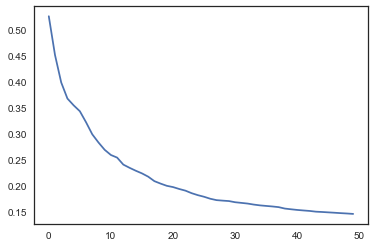

In [132]:
crossperf = BoostingCrossvalidation(train, columnscustomers_rfs, 'NumberOfCustomers', 50)
GradientBoosting_performances(crossperf)

# Double Prediction

Boosting 0 : 1 modelli - R2: 0.541325

Boosting 1 : 2 modelli - R2: 0.567245

Boosting 2 : 3 modelli - R2: 0.574431

Boosting 3 : 4 modelli - R2: 0.580450

Boosting 4 : 5 modelli - R2: 0.585568

Boosting 5 : 6 modelli - R2: 0.589129

Boosting 6 : 7 modelli - R2: 0.593790

Boosting 7 : 8 modelli - R2: 0.599826

Boosting 8 : 9 modelli - R2: 0.603549

Boosting 9 : 10 modelli - R2: 0.603073

Boosting 10 : 11 modelli - R2: 0.562936

Boosting 11 : 12 modelli - R2: 0.565253

Boosting 12 : 13 modelli - R2: 0.569143

Boosting 13 : 14 modelli - R2: 0.572461

Boosting 14 : 15 modelli - R2: 0.574706

Boosting 15 : 16 modelli - R2: 0.577088

Boosting 16 : 17 modelli - R2: 0.572749

Boosting 17 : 18 modelli - R2: 0.574782

Boosting 18 : 19 modelli - R2: 0.576698

Boosting 19 : 20 modelli - R2: 0.573361

Boosting 20 : 21 modelli - R2: 0.572521

Boosting 21 : 22 modelli - R2: 0.573337

Boosting 22 : 23 modelli - R2: 0.574001

Boosting 23 : 24 modelli - R2: 0.574903

Boosting 24 : 25 modelli - R2: 0.57

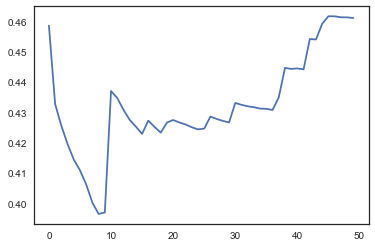

In [130]:
crossperf = DoubleBoostingCrossvalidation(train, columnscustomers_rfs, 'NumberOfCustomers', columnssales_rfs, 'NumberOfSales', 50)
GradientBoosting_performances(crossperf)